# Working with Uganda Dataset

## Name: Victor Agaba

## Date: 2024-08-12

***

#### NOTES

Remove count influence (???)

Implement conversions from angle of incidence

Implement free surface corrections

In [64]:
import sys, os, importlib
package_path = os.path.abspath('..')    
if package_path not in sys.path:
    sys.path.append(package_path)
from package import functions as fn
from package import model as sm
from package import optimizer as opt
from package import plots
import numpy as np, pandas as pd

***
#### Data Preprocessing
***

In [65]:
# events data
data_path = '../data/ug_data.csv'
data = pd.read_csv(data_path, header=0)
data = data.replace(np.nan, '', regex=True)

# shift errors to their own columns
amp_types = ['Raw', 'LP', 'BP']
og_cols = []
error_cols = []
for col in data.columns:
    for amp_type in amp_types:
        if amp_type in col:
            og_cols.append(col)
            error_cols.append(f'{col} error')

for col in error_cols:
    data[col] = np.nan

for i in range(1, len(data), 2):
    for j in range(len(og_cols)):
        data.at[i, error_cols[j]] = data.at[i-1, og_cols[j]]

data = data.drop(data.index[::2])
data.index = range(len(data))

print(data.head())
data

  Item    Event Id Magnitude      Origin time Longitude Latitude Depth  \
0  8.0  usp000a8sp       4.9  1/31/2001 19:15    29.494    0.466  27.7   
1  7.0  usp000hx9x       5.0   3/15/2011 3:25    31.231    1.746  10.0   
2  6.0  usb000i4t5       5.2   7/2/2013 13:33    30.907    1.606  10.0   
3  5.0  usb000i67t       5.7   7/3/2013 19:21    30.894    1.537  10.1   
4  4.0  usb000i6hl       5.1   7/3/2013 22:22    30.818    1.548  10.0   

  Station Location Azimuth: BHR  ... Raw: SH error Raw: SZ error LP: P error  \
0    MBAR   Uganda        129.0  ...       28400.0       30000.0       191.0   
1    KMBO      DRC        115.0  ...        4810.0        3570.0      2580.0   
2    MBAR   Uganda        186.0  ...      210000.0      214000.0     12200.0   
3    MBAR   Uganda        184.0  ...      756000.0      645000.0     12000.0   
4    MBAR   Uganda        185.0  ...      312000.0      288000.0      4160.0   

  LP: SV error LP: SH error LP: SZ error BP: P error  BP: SV error  \
0   

,Item,Event Id,Magnitude,Origin time,Longitude,Latitude,Depth,Station,Location,Azimuth: BHR,...,Raw: SH error,Raw: SZ error,LP: P error,LP: SV error,LP: SH error,LP: SZ error,BP: P error,BP: SV error,BP: SH error,BP: SZ error
0,8.0,usp000a8sp,4.9,1/31/2001 19:15,29.494,0.466,27.7,MBAR,Uganda,129.0,...,28400.0,30000.0,191.0,15100.0,4270.0,7700.0,89.0,52200.0,27900.0,29100.0
1,7.0,usp000hx9x,5.0,3/15/2011 3:25,31.231,1.746,10.0,KMBO,DRC,115.0,...,4810.0,3570.0,2580.0,1670.0,4540.0,3230.0,28.2,2270.0,1400.0,1720.0
2,6.0,usb000i4t5,5.2,7/2/2013 13:33,30.907,1.606,10.0,MBAR,Uganda,186.0,...,210000.0,214000.0,12200.0,25000.0,8620.0,19800.0,33.6,43300.0,18100.0,23800.0
3,5.0,usb000i67t,5.7,7/3/2013 19:21,30.894,1.537,10.1,MBAR,Uganda,184.0,...,756000.0,645000.0,12000.0,179000.0,37900.0,104000.0,461.0,996000.0,721000.0,544000.0
4,4.0,usb000i6hl,5.1,7/3/2013 22:22,30.818,1.548,10.0,MBAR,Uganda,185.0,...,312000.0,288000.0,4160.0,24900.0,35100.0,15800.0,191.0,84400.0,40100.0,45400.0
5,3.0,us10006nkx,5.9,9/10/2016 12:27,31.6181,-1.0355,40.0,MBAR,L.Vic Region,296.0,...,4160000.0,1120000.0,762000.0,978000.0,398000.0,1030000.0,4960.0,1370000.0,836000.0,939000.0
6,2.0,us2000a2mp,5.3,7/30/2017 7:02,29.7824,-0.22,10.0,MBAR,DRC,110.0,...,263000.0,839000.0,3630.0,263000.0,48800.0,125000.0,2870.0,325000.0,155000.0,251000.0
7,10.0,us7000dld3,4.2,3/20/2021 17:07,31.187,2.499,10.0,MBAR,Uganda,188.0,...,3090.0,4470.0,610.0,1080.0,683.0,771.0,16.0,5200.0,2470.0,3670.0
8,11.0,us6000e39d,4.6,4/14/2021 2:20,30.385,1.172,10.0,MBAR,Uganda,169.0,...,26500.0,23800.0,1650.0,7260.0,2500.0,4090.0,16.0,28700.0,20100.0,18900.0
9,12.0,us7000edwz,4.6,6/17/2021 17:49,33.406,-0.661,10.0,MBAR,L.Vic Region,271.0,...,11300.0,13000.0,79.6,1830.0,693.0,1350.0,15.8,11100.0,9080.0,10300.0


In [66]:
# velocity model
velocity_path = '../data/IASP91_IDV.csv'
velocity_model = pd.read_csv(velocity_path, header=1)
print(velocity_model.head())

   Depth[unit="km"]  Radius[unit="km"]  Vp[unit="km/s"]  Vs[unit="km/s"]
0               0.0             6371.0              5.8             3.36
1               1.0             6370.0              5.8             3.36
2               2.0             6369.0              5.8             3.36
3               3.0             6368.0              5.8             3.36
4               4.0             6367.0              5.8             3.36


***
#### Source Mechanism
***

In [67]:
idx = 8

# # BUG: fix model.filter_outliers
# # maybe don't use a statistical threshold
# # make sure they're all of one type
# idx = 3
# idx = 8

az_type = 'BHR'
azimuth = data.iloc[idx][f'Azimuth: {az_type}']
wave_types = ['P', 'S']
takeoff_angles = [data.iloc[idx][f'Takeoff: {wave_type}n']
                  for wave_type in wave_types]

# find in velocity model where depth is closest to depth
event_depth = data.iloc[idx]['Depth']
ref_depth_col = 'Depth[unit="km"]'
ref_depths = velocity_model[ref_depth_col]
ref_depth_idx = np.abs(ref_depths - event_depth).idxmin()
columns = ['Vp[unit="km/s"]', 'Vs[unit="km/s"]']
ref_depth = velocity_model.iloc[ref_depth_idx]
velocities = ref_depth[columns].values

# need to correct for measurement stuff
amp_filter = 'Raw'
amps = ['P', 'SV', 'SH']
response = 1e7
frequency = 3.5
Ao = np.array([data.iloc[idx][f'{amp_filter}: {amp}'] for amp in amps])/(response*frequency)
Uo = np.array([data.iloc[idx][f'{amp_filter}: {amp} error'] for amp in amps])

***
#### Hybrid Inversion
***

In [ ]:
importlib.reload(fn)
importlib.reload(sm)
importlib.reload(opt)
importlib.reload(plots)

# initialize model
inv_model = sm.RadiationModel(np.deg2rad(azimuth), takeoff_angles, velocities)
inv_model.set_Ao(Ao)


# tune hyperparameters
config = opt.get_config()

# initialize random hybrid search: many runs
num_runs = 100
starts = fn.random_params(num_runs)

# # initialize systematic hybrid search: debugging
# step_size = 30
# starts = fn.systematic_params(step_size)
# num_runs = len(starts)

# multi-start optimization
inv_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_runs}')
    opt.minimize(inv_model, config, start)
    
print(f'Convergence rate: {inv_model.get_convergence_rate():.0f}%')

Run 0 of 100
Run 10 of 100
Run 20 of 100
Run 30 of 100
Run 40 of 100
Run 50 of 100
Run 60 of 100
Run 70 of 100
Run 80 of 100
Run 90 of 100
Convergence rate: 99%


Axis: T
Optimal parameters: [155.96811014  40.33722048  13.7018195 ]
Search error: 0.5920984122994514 degrees


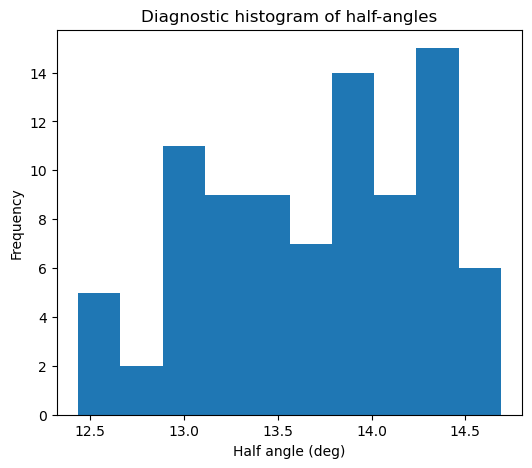

In [69]:
params, error, position = inv_model.get_optimal_parameterization()
name = 'T' if position == 0 else 'P'

print(f'Axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

plots.half_angles(inv_model, bins=10)

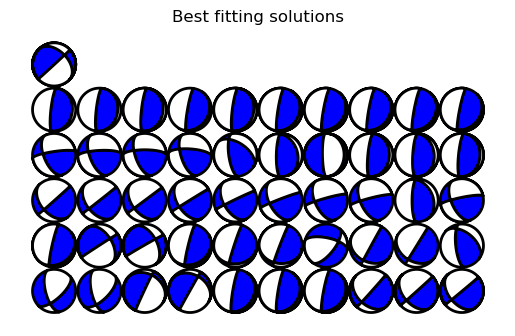

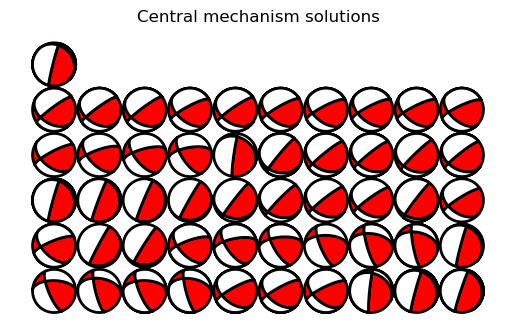

In [70]:
# beachball plots
plots.beachballs(inv_model, central=False, order_by='strike')
plots.beachballs(inv_model, central=True, order_by='strike')

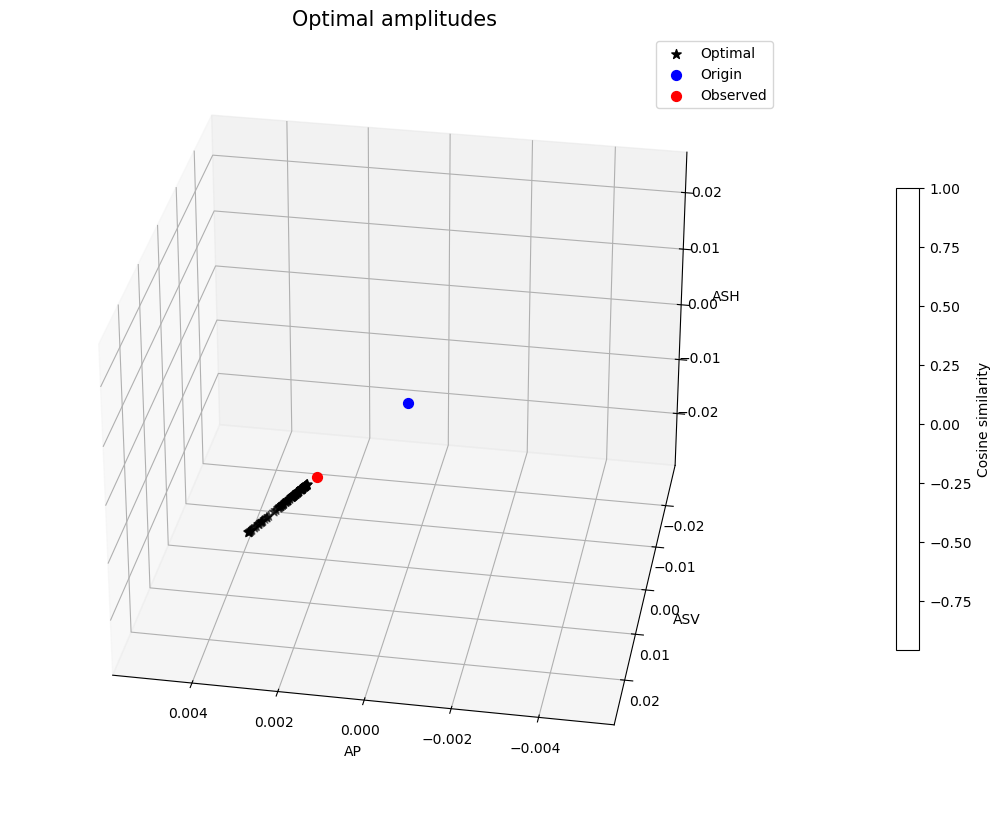

In [71]:
# amplitude plot
# TODO: include marker at origin
plots.amplitudes(inv_model, azim=100, elev=30, s=50, alpha=0, iterates=True,
                 observed=True)

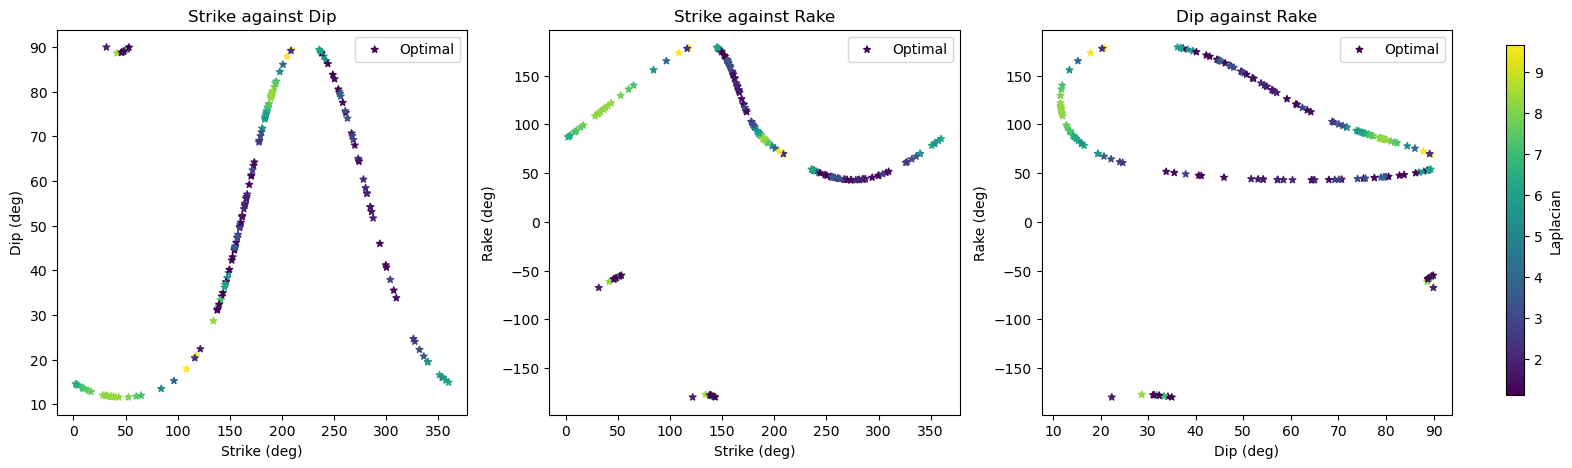

In [74]:
# iterate plot - sdr space
plots.iterates_2D(inv_model, s=25, optimal=True, index=2, cmap='viridis')
# plots.iterates_2D(inv_model, s=1, optimal=False, index=0)
# plots.iterates_2D(inv_model, s=1, optimal=False, index=1)

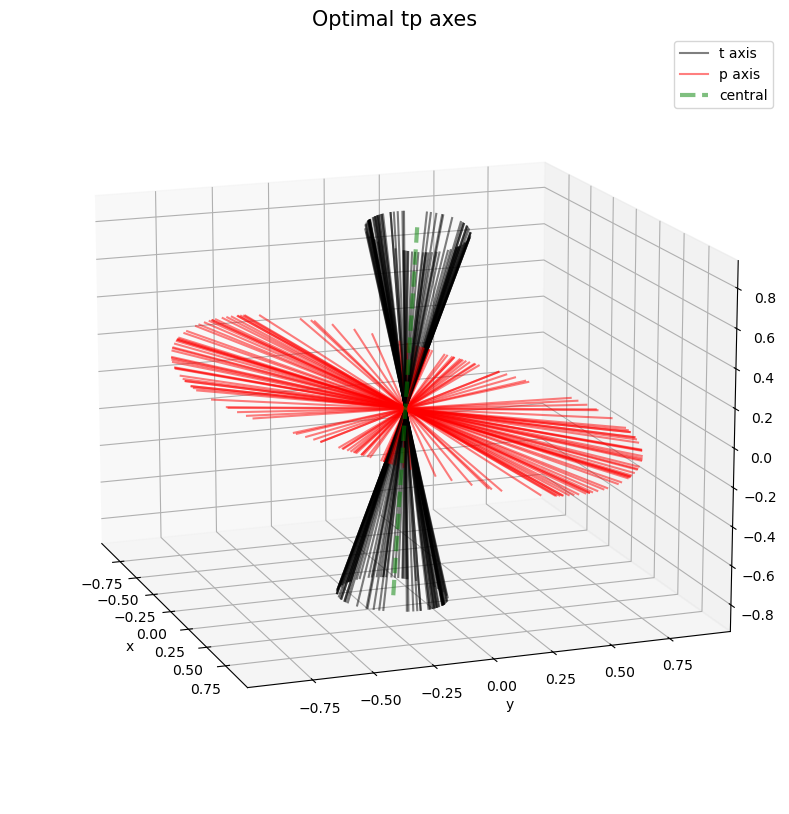

In [73]:
# optimal plot - tp space, collapse to central
plots.tp_axes(inv_model, azim=-20, elev=15, half=False, central=False)

***
#### Uncertainty Propagation
***

In [63]:
dd, num_samples = 15, 50
# dd, num_samples = 30, 15  # debugging
inv_model.set_Uo(Uo)
inv_model.set_chi2(1e-8)
inv_model.sample_amplitudes(dd, num_samples)
plots.sampled_amplitudes(inv_model, cmap='rainbow', s=25, azimuth=200, elevation=30)

AssertionError: Confidence ellipsoid is too big: c1 = 7.169819620472546e-17

In [ ]:
num_runs, print_every = 30, 0
inv_model.monte_carlo(dd, num_samples, num_runs, print_every)

Sample 0 of 55
Sample 1 of 55
Sample 2 of 55
Sample 3 of 55
Sample 4 of 55


KeyboardInterrupt: 

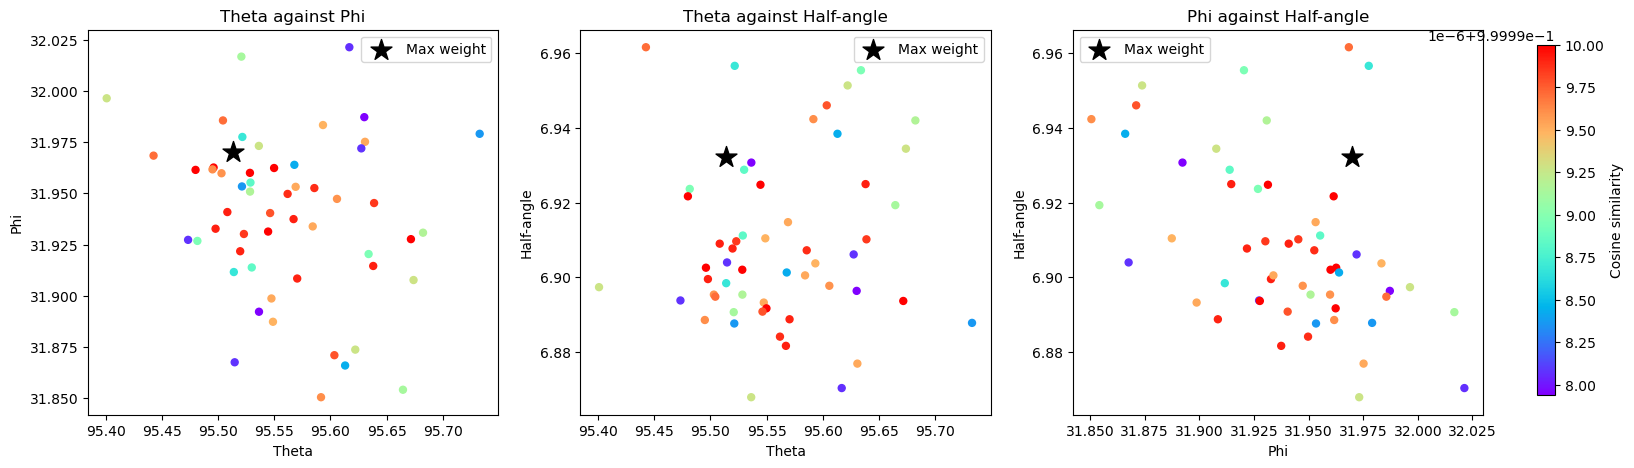

In [ ]:
# monte carlo plot - cone space
error_threshold = 5
inv_model.post_filter(threshold=error_threshold)
plots.uncertainty_2D(inv_model, s=25, scale=0)
# plots.uncertainty_3D(inv_model, elev=30, azim=45, s=25)

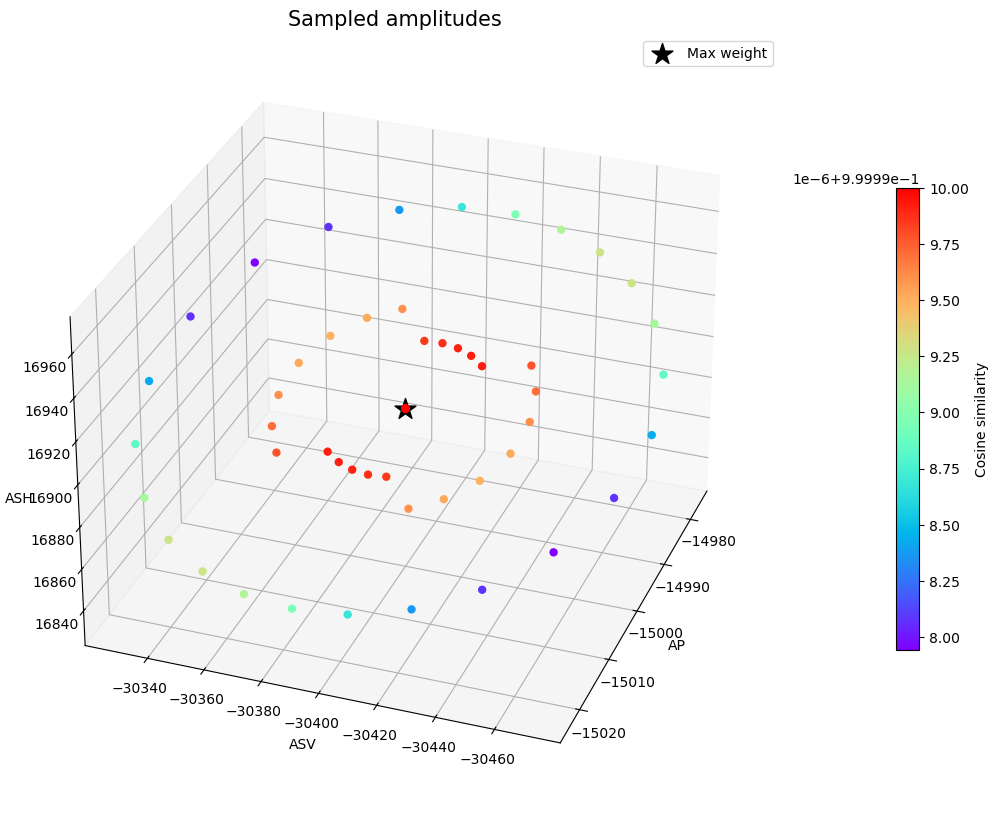

In [ ]:
plots.sampled_amplitudes(inv_model, cmap='rainbow', s=25, azimuth=200, elevation=30)

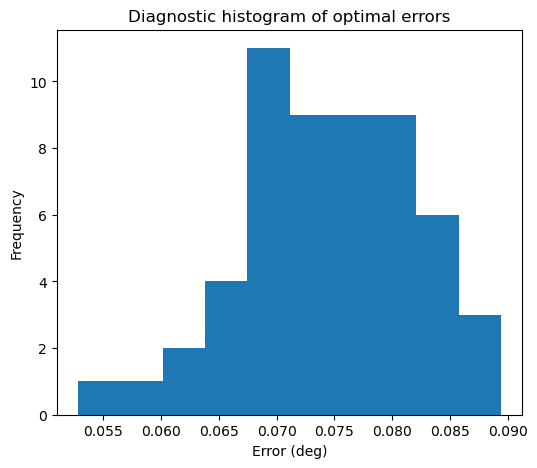

In [ ]:
# diagnostic plot of monte carlo errors
plots.optimal_errors(inv_model, bins=10)

***
INSIGHTS:
* For very small errors, we can still approximate a covariance ellipse using PCA
* Laplacian generally points away from the transformation's center of mass
* Include alpha level on uncertainty plot (perhaps split by mode)
* See if the central mechanisms are really Kagan angles
* The modes are begging to show on a continuum!
* Observations are so much bigger than simulations for idx=0

***